# Data Scientist Challenge - Airlines

El siguiente notebook consiste en un ejercicio parar un desafío de análisis y predicción sobre el atraso de arrivo de vuelos comerciales.
El mismo se descompone en los siguientes capítulos:

1. Setup
2. Exploratory Data Analysis
3. Data Wrangling
4. Delay Rate Calculation
5. Feature Selection, Engineering and Modeling <br>
    5.1 Feature Selection and Engineering<br>
    5.2 Logistic Regression<br>
    5.3 Support Vector Machines<br>
6. Considerations and Further Analysis

<a id=setup></a>

# 1. Setup

En primer lugar instalamos las librerías que utilizaremos para nuestro estudio. Las mismas se encuentran especificadas en un archivo "requirements.txt".

A su vez definimos la ruta del repositorio, correspondientes carpetas y agregamos el directorio "utils" al directorio de sistema (de este modo podemos importar el código allí alocado como una librería más).

In [414]:
! pip install -r requirements.txt


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [415]:
import os, sys
import pandas as pd
from pylab import rcParams
import numpy as np
import datetime
from datetime import timedelta, date, time
from random import randint
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from sklearn.compose import make_column_transformer

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

import pickle

In [416]:
root_path = os.getcwd()
data_path = os.path.join(root_path, 'data')
models_path = os.path.join(root_path, 'models')
utils_path = os.path.join(root_path, 'utils')
sys.path.append(utils_path)

In [417]:
from utils import temporada, atraso, periodo, delay_rate, get_categs_order, find_outliers

Importamos el archivo .csv como un Pandas DataFrame. 
Realizamos algunas transformaciones:
- Convertimos el formato de las columnas "Fecha-I" y "Fecha-O" a fecha para poder tratarlas correctamente.
- Reemplazamos los caracteres "-" por "_" y llevamos todos los caracteres a minúsuca. Esta convención facilita el tratamiento de una tabla si posteriormente es utilizada en un ETL ("Extract, Transfor and Load" data integration process)

In [418]:
# Import data, transform some columns format

data = os.path.join(data_path, 'dataset_SCL.csv')

df = pd.read_csv(data, parse_dates=['Fecha-I', 'Fecha-O'])
df.columns = df.columns.str.replace('-', '_')
df.rename(str.lower, axis=1, inplace=True)

/tmp/ipykernel_5163/3032782260.py:5: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data, parse_dates=['Fecha-I', 'Fecha-O'])


<a id=eda></a>

# 2. Exploratory Data Analysis

Si inspeccionamos la data, encontramos 68.206 casos y 18 categorías. Estas últimas se encuentran en 3 formatos: "fecha-I" y "fecha-O" son efectivamente fechas (año-mes-día hora:minuto:segundo); "dia", "mes" y "año" son intervales; el resto son variables categóricas. 

Estos aspectos los tendremos que tener en consideración tanto a la hora de inspeccionar los datos como de tratarlos para su utilización en un modelo predictivo.

In [419]:
print('Data Frame shape: {}'.format(df.shape))

Data Frame shape: (68206, 18)


In [420]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha_i    68206 non-null  datetime64[ns]
 1   vlo_i      68206 non-null  object        
 2   ori_i      68206 non-null  object        
 3   des_i      68206 non-null  object        
 4   emp_i      68206 non-null  object        
 5   fecha_o    68206 non-null  datetime64[ns]
 6   vlo_o      68205 non-null  object        
 7   ori_o      68206 non-null  object        
 8   des_o      68206 non-null  object        
 9   emp_o      68206 non-null  object        
 10  dia        68206 non-null  int64         
 11  mes        68206 non-null  int64         
 12  año        68206 non-null  int64         
 13  dianom     68206 non-null  object        
 14  tipovuelo  68206 non-null  object        
 15  opera      68206 non-null  object        
 16  siglaori   68206 non-null  object       

Podemos ver un descriptivo de los primeros 5 casos para tener una visión más general de qué contenido hay en cada celda y familiarizarnos mejor con la tabla.

In [421]:
df.head()

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Podemos observar la distribución de las variables numéricas. Es particularmente interesante ver el contraste entre la fecha programada y la fecha de origen, en grandes razgos las distribuciones son muy similares lo cual nos habla de que no habrían atrasos en términos de días, seguramente nos encontraremos más adelante en el análisis atrasos en torno a minutos, los cuales son más sutiles pero de gran impacto de negocio.

Podemos ver que prácticamente todos los datos corresponden al año 2017, que el día del mes en el que se realizan más viajes es sobre el 30 y que el período Diciembre-Febrero es el que presenta mayor cantidad de vuelos.

array([[<AxesSubplot:title={'center':'fecha_i'}>,
        <AxesSubplot:title={'center':'fecha_o'}>],
       [<AxesSubplot:title={'center':'dia'}>,
        <AxesSubplot:title={'center':'mes'}>],
       [<AxesSubplot:title={'center':'año'}>, <AxesSubplot:>]],
      dtype=object)

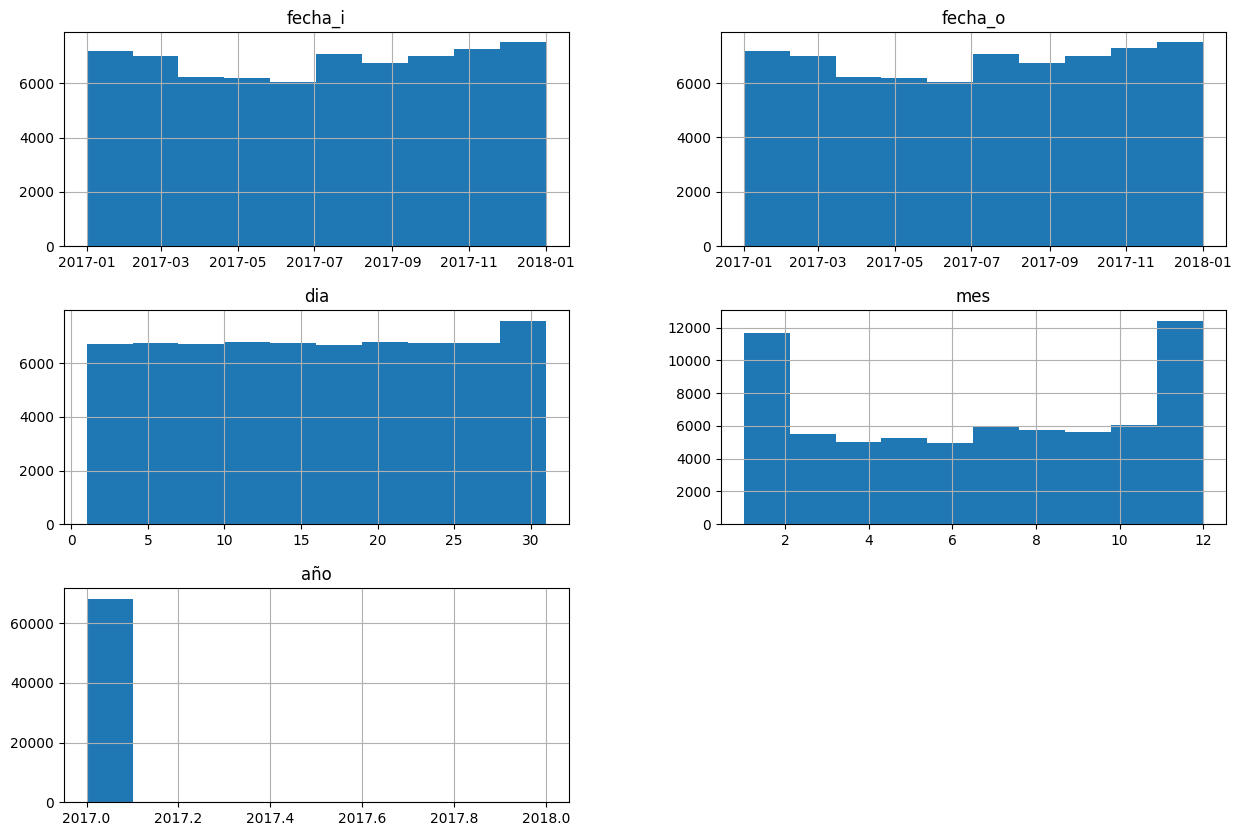

In [422]:
df.hist(figsize=(15,10))

In [423]:
df.describe()

,dia,mes,año
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


En lo referido a variables categóricas podemos ver algunos insights generales. En el siguiente gráfico se ven las ciudades con más frecuencia de destino:

<AxesSubplot:>

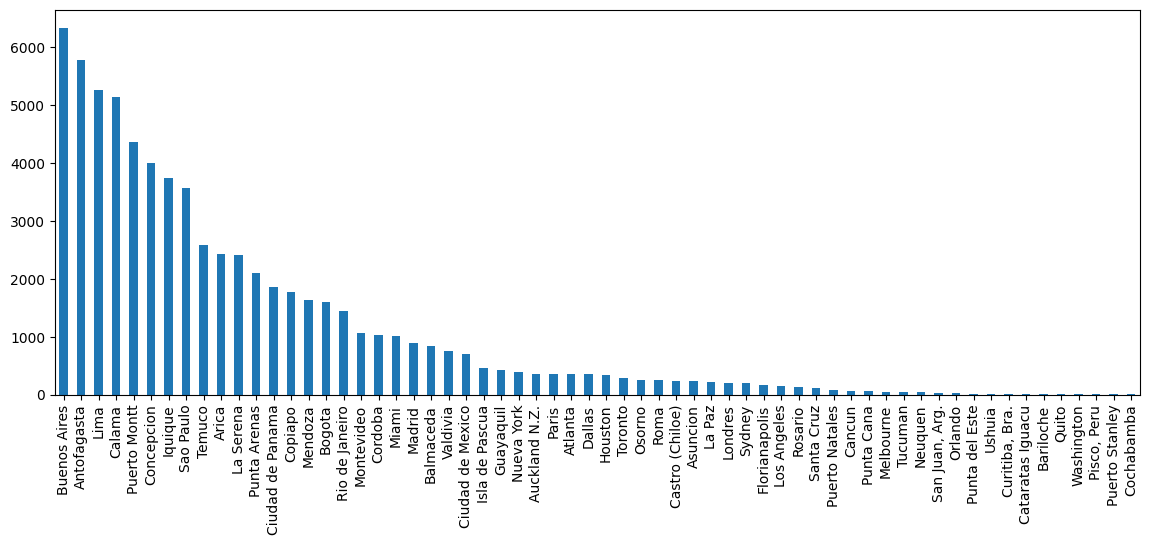

In [424]:
df['siglades'].value_counts().plot(kind='bar', figsize=(14,5))

En otra visualización categórica llama la atención como la distribución de los códigos de aerolínea de vuelo programado y los códigos de aerolínea de vuelo operado no coinciden perfectamente. Vale la pena revisar esta información ya que de ser así quiere decir que existen vuelos que se programaron relizarse en una aerolínea pero fueron realizados en otra.

/tmp/ipykernel_5163/37417213.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


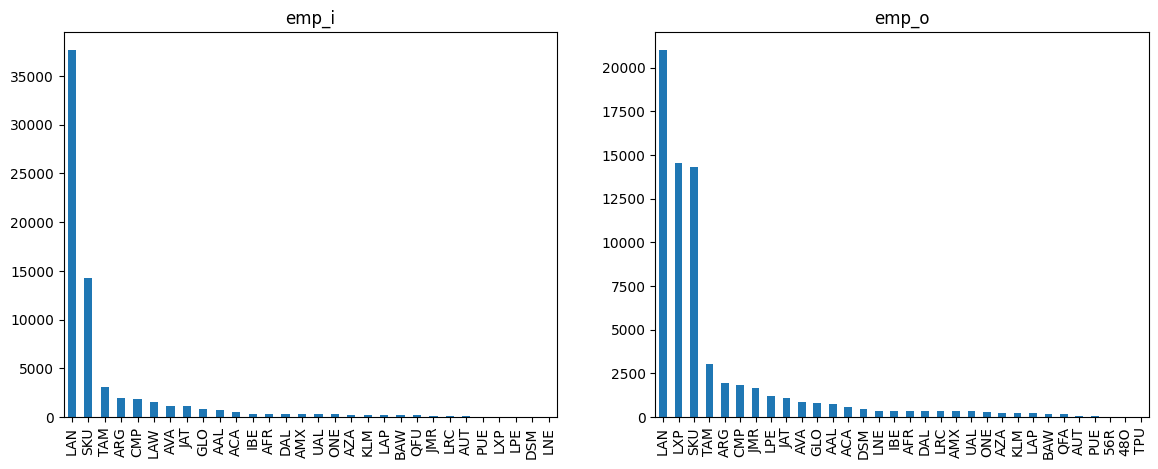

In [425]:
categorical_features = ["emp_i", "emp_o"]
fig, ax = plt.subplots(1, len(categorical_features))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i], figsize=(14,5)).set_title(categorical_feature)
fig.show()

A su vez, podemos complementar este contraste con la distribución de la variable "opera". Vemos así que el nombre de la aerolínea de operación no contiene la misma información que el código de la aerolínea.

Una interpretación del cruce de estos 3 gráficos es que existen situaciones del estilo: Aprox. 40.000 vuelos son operados por Grupo LATAM, se programaron en su mayoría vuelos para los códigos LAN, SKU y TAM, pero la operación real la mayoría de los vuelos son ejecutados por los códigos LAN, LXP y SKU. Estas diferencias entre planificado y operación podrían dar cuenta de atrasos.

<AxesSubplot:>

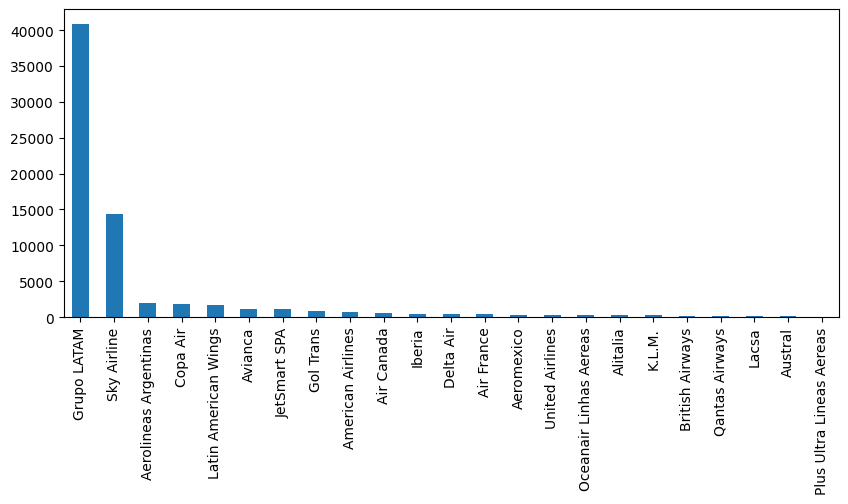

In [426]:
df['opera'].value_counts().plot(kind='bar', figsize=(10,4))

En relación al número de vuelos programados, vemos que existen 750 categorías en todo el dataset. También se aprecia que de estas, algunas categorías agrupan un alto número de vuelos (ej. la categoría "174" presentó 686 casos), mientras que por otro lado hay un alto número de categorías con pocos vuelos.

In [427]:
df['vlo_i'].value_counts()

174     686
11      645
116     608
150     557
162     553
       ... 
1158      1
368       1
9955      1
9701      1
1218      1
Name: vlo_i, Length: 750, dtype: int64

No encontramos casos duplicados en el data frame, esto es un buen criterio de salubridad en nuestros datos

In [428]:
len(df[df.duplicated()])

0

Por último, podemos ver que la ciudad de origen de todos los vuelos es "Santiago". A diferencia las ciudades de destino sí presentan variación.

In [429]:
df.siglaori.value_counts()

Santiago    68206
Name: siglaori, dtype: int64

In [430]:
df.siglades.value_counts()

Buenos Aires      6335
Antofagasta       5786
Lima              5270
Calama            5146
Puerto Montt      4357
                  ... 
Quito                2
Washington           1
Pisco, Peru          1
Puerto Stanley       1
Cochabamba           1
Name: siglades, Length: 62, dtype: int64

Sumamos a nuestro análisis descriptivo una inspección de outliers. Para esto llamamos a la función local "find_outliers" y la aplicamos a las columnas no categóricas del data set.

La función nos devuelve 2 posibles outliers en los índices 66.947 y 66.918. Luego de una inspección de estos índeces observamos que lo que hace interpretarlos como outliers es que son los únicos dos casos del año 2018, por lo que no encontramos justificación a dropear estos dos casos (de todos modos, más adelante en el notebook se dropea la columna año por no aportar varianza en el análisis predictivo).

In [431]:
bad_indexes = []
for col in df.columns:
    if df[col].dtype in ["int64","float64"]:
        bad_indexes.append(find_outliers(df[col]))

bad_indexes = set(list(np.concatenate(bad_indexes).flat))
print(bad_indexes)
print(len(bad_indexes))

{66947.0, 66918.0}
2


In [432]:
df.iloc[[66947, 66918]]

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades
66947,2017-12-31 23:40:00,622,SCEL,MMMX,LAN,2018-01-01 00:12:00,622.0,SCEL,MMMX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Ciudad de Mexico
66918,2017-12-31 23:55:00,602,SCEL,KLAX,LAN,2018-01-01 00:02:00,602.0,SCEL,KLAX,LAN,1,1,2018,Lunes,I,Grupo LATAM,Santiago,Los Angeles


Por último, cabe la pena señalar un supuesto que tomaremos en consideración para todo nuestro análisis. Existen 5 variables que refieren a la operación del vuelo ('fecha_o', 'vlo_o', 'ori_o', 'des_o', 'emp_o'), consideramos aquí que esa información se obtiene luego de que el vuelo culminó y llegó a destino, esto es lo que las diferencia de las variables sobre el vuelo programado ('fecha_i', 'vlo_i', 'ori_i', 'des_i', 'emp_i').

Dado que nuestro análisis final buscará predecir categóricamente los atrasos de vuelos y tomando el supuesto de que en producción no se tendrá información sobre operación del vuelo (variables '_o'), las 5 variables de operación no serán incluidas en nuestros modelos. El dropeo se realiza más adelante en un apartado.

Conclusiones del análisis descriptivo:

- La mayoría de las variables son categóricas, para incluirlas en un modelo es muy probable que tengamso que hacer tratamiento
- En una primera inspección no encontramos casos duplicados, tampoco encontramos casos que conceptualmente sean outliers
- Las diferencias entre la llegada esperada y real de los vuelos rondan en torno a los minutos para la mayoría de los casos.
- Algunas variables que, dads su varianza, podrían tener impacto en el retraso de vuelos son: mes, día, emp_i, opera, vlo_i y/o sigla_des.
- Existen varaibles con casi nula o con nula variabiliad. Estas no deben ser incluídas en nuetros modelos.
- Tomando el supuesto de que las variables de operación (“_o”) se obtienen luego de que el vuelo culminó, no pueden ser incluídas en producción. Por este motivo se dropearán del análisis.

<a id=data-wrang></a>

# 3. Data Wrangling

A continuación generamos las cuatro columnas requeridas: "temporada_alta", "fid_min", "atraso_15" y "periodo_dia".
En busca de la reducción, reutilización y escalabilidad de nuestro código es que creamos funciones dentro del archivo "utils.py", las cuales importamos e implementamos en nuestro notebook llamándolas por medio de funciones lambda.

In [433]:
df['temporada_alta'] = df.apply(lambda x: temporada(x), axis=1)
df['dif_min'] = (df['fecha_o'] - df['fecha_i']) / np.timedelta64(1, 'm')
df['atraso_15'] = df.apply(lambda x: atraso(x, mins=15), axis=1)
df['periodo_dia'] = df.apply(lambda x: periodo(x), axis=1)

In [434]:
df[['fecha_o', 'fecha_i', 'temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']]

,fecha_o,fecha_i,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:33:00,2017-01-01 23:30:00,1,3.0,0,noche
1,2017-01-02 23:39:00,2017-01-02 23:30:00,1,9.0,0,noche
2,2017-01-03 23:39:00,2017-01-03 23:30:00,1,9.0,0,noche
3,2017-01-04 23:33:00,2017-01-04 23:30:00,1,3.0,0,noche
4,2017-01-05 23:28:00,2017-01-05 23:30:00,1,-2.0,0,noche
...,...,...,...,...,...,...
68201,2017-12-22 15:41:00,2017-12-22 14:55:00,1,46.0,1,tarde
68202,2017-12-25 15:11:00,2017-12-25 14:55:00,1,16.0,1,tarde
68203,2017-12-27 15:35:00,2017-12-27 14:55:00,1,40.0,1,tarde
68204,2017-12-29 15:08:00,2017-12-29 14:55:00,1,13.0,0,tarde


Guardamos estos nuevos features en la carpeta "data" bajo el nombre 'synthetic_features.csv'. Es importante recordar que este archivo se genera local pero no se "pushea" a la versión remota en GitHub dado que Git no está pensado para hacer version control de los datos, sino únicamente del código.

In [435]:
# Export synthetic_features.csv
df_syn_feat = df.copy()
df_syn_feat = df[['fecha_o', 'fecha_i', 'temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia']]
data_export = os.path.join(data_path, 'synthetic_features.csv')
df_syn_feat.to_csv(data_export)

<a id=delay-rate-calc></a>

# 4. Delay Rate Calculation

A continuación inspeccionamos la tasa de atraso. Definimos "tasa" como el valor porcentual de ocurrencia de una categoría o suceso sobre el total poblacional. En términos sencillos y para este problema la tasa de atraso correspondería entonces a "de 100 vuelos cuantos se atrasan", considerando 15 minutos como el margen de atraso.

Podemos primero realizar un conteo general sobre la cantidad de casos atrasados, allí se observan 55.592 vuelos sin atraso vs. 12.614 vuelos con atraso. La correspondiente tasa de atraso general es de 18.49%, esto nos indica a groso modo que casi un 20% de los vuelos presentan un atraso de más de 15 minutos.

In [436]:
df.dif_min.describe()

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64

In [437]:
tasa_atraso = delay_rate(df)
print("Tasa general de retraso:{} % | cada 100 vuelos, {} se retrasan 15 min".format(tasa_atraso, tasa_atraso))

Tasa general de retraso:18.49 % | cada 100 vuelos, 18.49 se retrasan 15 min


Como siguiente paso calculamos la tasa de atraso filtrada por las categorias solicitadas: destino, aerolíonea, mes del año, día de la semana, temporada y tipo de vuelo.

Viendo los presentes gráficos llama la atención como la tasa de atraso se descompone por destino, los aeropuertos de Quito, Puerto Stanley y Cochabamba presentan atraso mayor a 15 minutos en la totalidad de sus vuelos.

<AxesSubplot:xlabel='siglades'>

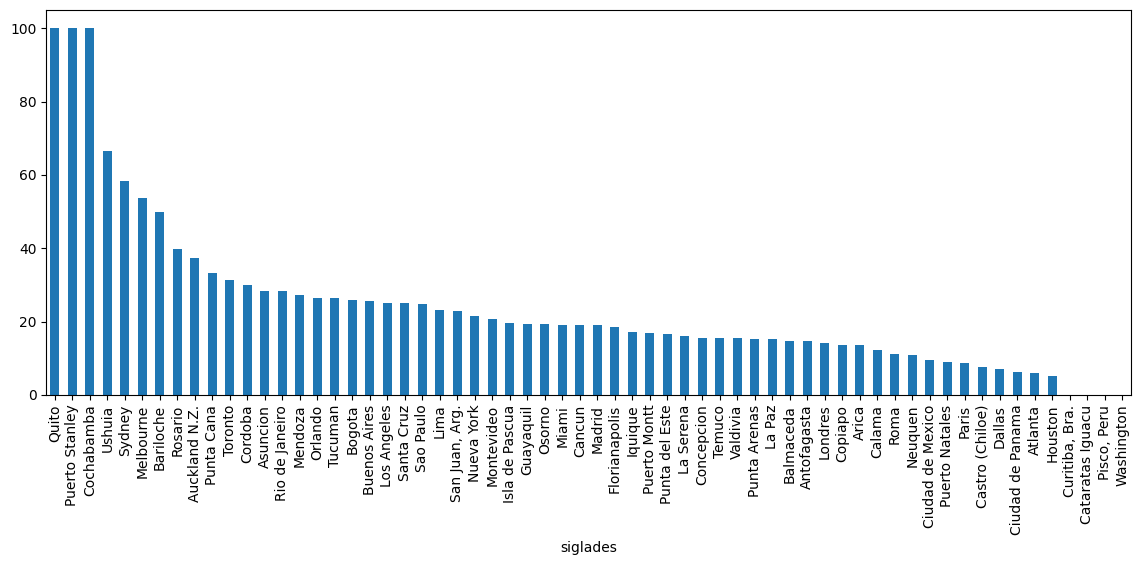

In [438]:
df.groupby(['siglades']).apply(delay_rate).sort_values(ascending=False).plot.bar(figsize=(14,5))

Si analizamos en términos de aerolíneas, Plus Ultra Lines Aereas y Qantas Airways presentan atraso en más de la mitad de sus vuelos. Air Canada, Latin America Wings y Goi Trans les siguen en la lista con tasas de atraso de entre el 30% y 50%. En una visión más global, los vuelos internacionales presentan una tasa de retraso del 22.56% mientras que los nacionales se ubican en el orden del 15.06%

<AxesSubplot:xlabel='opera'>

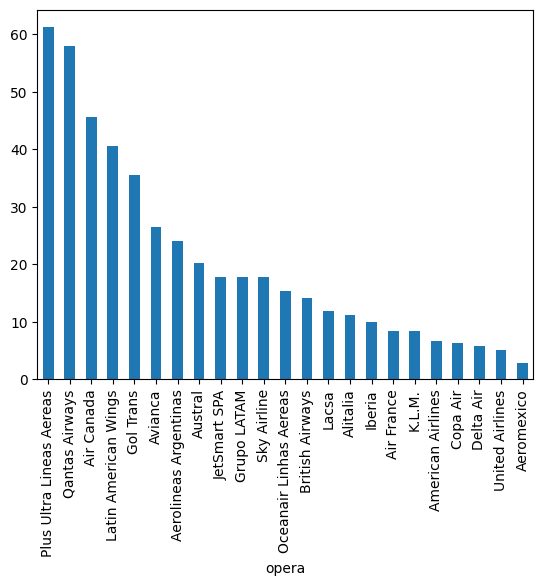

In [439]:
df.groupby(['opera']).apply(delay_rate).sort_values(ascending=False).plot.bar()

Los meses que presentan mayor tasa de atraso son el 7, 12, 10 y 11 (Julio, Diciembre, Octubre y Noviembre, respectivamente) con tasas que van entre el 20%(aprox) y 30%. En el resto de los meses la tasa de atraso se ubica entre el 10% y el 20%. Este comportamiento coincide con las fechas de temporada alta o fechas festivas, si agrupamos las fechas por esta variable observamos que el atraso presenta una tasa del 20.31% en temporada alta frente a 17.57% en temporada baja.

<AxesSubplot:xlabel='mes'>

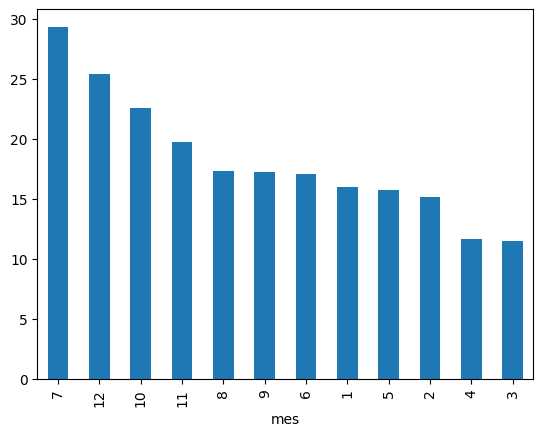

In [440]:
df.groupby(['mes']).apply(delay_rate).sort_values(ascending=False).plot.bar()

Por otro lado, la distribución de atraso se mantiene bastante estable en relación a los días del mes. Se observa de todos modos un leve aumento en los días de mitad de mes (día 15 y sus aledaños).

<AxesSubplot:xlabel='dia'>

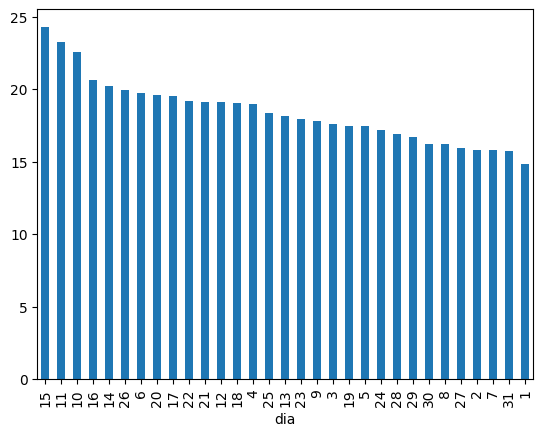

In [441]:
df.groupby(['dia']).apply(delay_rate).sort_values(ascending=False).plot.bar()

Al analizar la tasa de atraso marginal, tanto por temporada como por tipo de vuelo, observamso un comportamiento similar: La tasa para los vuelos en temporada alta oscila en torno al 20%, mientras que en temporada baja lo hace en torno al 17%. Para los vuelos internacionales la tasa de atraso es cercana al 23% mientras que para los nacionales se observan valores del 15%.

In [442]:
df.groupby(['temporada_alta']).apply(delay_rate).sort_values(ascending=False)

temporada_alta
1    20.31
0    17.57
dtype: float64

In [443]:
df.groupby(['tipovuelo']).apply(delay_rate).sort_values(ascending=False)

tipovuelo
I    22.56
N    15.06
dtype: float64

La información ilustrada será de gran utilidad a la hora de categorizar las variables dependientes de nuestro modelo. Por ejemplo, las variables "siglades" y "opera" contienen gran número de categorías, las cuales a priori no presentan un orden jerárquico cuantitativo, pero gracias a nuestra inspección por ratio de atraso podemos ahora sí ordenarlas de mayor a menor según los valores mostrados en los gráficos. Tomaremos esto como criterio para realizar Ordinal Encodering.

A modo ilustrativo, puede apreciarse que el orden de las categorías respeta el orden del gráfico anterior:

In [444]:
df.groupby(['siglades']).apply(delay_rate).sort_values(ascending=False).keys()

Index(['Quito', 'Puerto Stanley', 'Cochabamba', 'Ushuia', 'Sydney',
       'Melbourne', 'Bariloche', 'Rosario', 'Auckland N.Z.', 'Punta Cana',
       'Toronto', 'Cordoba', 'Asuncion', 'Rio de Janeiro', 'Mendoza',
       'Orlando', 'Tucuman', 'Bogota', 'Buenos Aires', 'Los Angeles',
       'Santa Cruz', 'Sao Paulo', 'Lima', 'San Juan, Arg.', 'Nueva York',
       'Montevideo', 'Isla de Pascua', 'Guayaquil', 'Osorno', 'Miami',
       'Cancun', 'Madrid', 'Florianapolis', 'Iquique', 'Puerto Montt',
       'Punta del Este', 'La Serena', 'Concepcion', 'Temuco', 'Valdivia',
       'Punta Arenas', 'La Paz', 'Balmaceda', 'Antofagasta', 'Londres',
       'Copiapo', 'Arica', 'Calama', 'Roma', 'Neuquen', 'Ciudad de Mexico',
       'Puerto Natales', 'Paris', 'Castro (Chiloe)', 'Dallas',
       'Ciudad de Panama', 'Atlanta', 'Houston', 'Curitiba, Bra.',
       'Cataratas Iguacu', 'Pisco, Peru', 'Washington'],
      dtype='object', name='siglades')

En "utils.py" alojamos una función local para crear objetos con las categorías de una respectiva variable categórica, ordenadas en función de la tasa de atraso, con la misma lógica que el output mostrado en el cuadrante anterior. Aplicamos esta función a todas las variables categóricas de interés:

In [446]:
# Los números de los vuelos deben ser tratados como strings.
df.vlo_i = df.vlo_i.astype(str)
df.emp_o = df.emp_o.astype(str)

# Aplicamos la función para extraer categorías en orden.
vlo_i_categs = get_categs_order(df, 'vlo_i')
des_i_categs = get_categs_order(df, 'des_i')
emp_i_categs = get_categs_order(df, 'emp_i')
dianom_categs = get_categs_order(df, 'dianom')
tipovuelo_categs = get_categs_order(df, 'tipovuelo')
opera_categs = get_categs_order(df, 'opera')
sigla_des_categs = get_categs_order(df, 'siglades')
periodo_dia_categs = get_categs_order(df, 'periodo_dia')

# Guardamos las categorías en una lista.
categories = [vlo_i_categs, des_i_categs, emp_i_categs, dianom_categs,
                tipovuelo_categs, opera_categs, sigla_des_categs, periodo_dia_categs]


<a id=feature-eng-mod></a>

# 5. Feature Selection, Engineering & Modeling

<a id=feature-eng-mod-1></a>

## 5.1 Feature Selection and Engineering

En el siguiente apartado pasaremos a trabjar en la selección e ingeniería de features, definición de modelos y entrenamiento de los mismos.

Si nuestro problema de estudio consiste en estimar la probabilidad de atraso o no de un vuelo, nos estamos enfrentando entonces a un problema de clasificación binomial (1-atraso, 0-no entraso), en el cual queremos poder estimar la probabilidad de pertencer a una categoría o la otra.

De este modo, nuestra variable "target" será claramente "atraso_15", mientras que una selección de las otras serán las variables explicativas.

### Dropeo de variables

Como primer paso de nuestro feature engineering realizamos dropeo de variables no relevantes en base a 3 criterios:
- Dropeo variables que no presentan variabilidad, por lo que no aportan explicación a ningún modelo: "ori_i", "ori_o", "siglaori"
- Dropeo de variables que presentan alta colinealidad con la variable a predecir: "dif_min" ("atraso_15" se crea en base a un if conditional de esta variable)
- Dropeo de varaibles que replican información de otras variables: "fecha_i", "fecha_o" (el componente año-mes-día ya está presente en otras variables, mientras que el componente hora-min-seg tiene colinealidad alta con la variable a predecir)
- Dropeo de variables que conceptualmente no pueden incorporarse al modelo. Ya habíamos mencionado el supuesto de que las variables "_o" no estarían presentes en producción. Podemos decir que no presetnan antecedencia temporal con la variable a predecir, por lo que deberían ser retiradas.

In [447]:
print(df.ori_i.value_counts())
print(df.ori_o.value_counts())
print(df.siglaori.value_counts())

SCEL    68206
Name: ori_i, dtype: int64
SCEL    68206
Name: ori_o, dtype: int64
Santiago    68206
Name: siglaori, dtype: int64


In [448]:
# Drop columns that not add variability
df= df.drop('ori_i', axis=1)
df= df.drop('ori_o', axis=1)
df= df.drop('siglaori', axis=1)

# La variable año presenta variabilidad casi nula, podemos también dropearla
df= df.drop('año', axis=1)

# Drop columnas fecha
df= df.drop('fecha_i', axis=1)
df= df.drop('fecha_o', axis=1)

# Drop dif_min
df= df.drop('dif_min', axis=1)

# Drop todas las columnas "_o"
df = df.drop('vlo_o', axis=1)
df = df.drop('des_o', axis=1)
df = df.drop('emp_o', axis=1)

### Revisión de variables

In [449]:
df.columns

Index(['vlo_i', 'des_i', 'emp_i', 'dia', 'mes', 'dianom', 'tipovuelo', 'opera',
       'siglades', 'temporada_alta', 'atraso_15', 'periodo_dia'],
      dtype='object')

La mayoría de nuestras variables son del tipo categóricas, y si bien tanto la regresión logística como otros modelos soportan regresores categóricos, estos no pueden ser suministrados directamente (los valores no pueden ser "strings") sino que deben ser "encodeados" con algún criterio.

In [450]:
df.dtypes

vlo_i             object
des_i             object
emp_i             object
dia                int64
mes                int64
dianom            object
tipovuelo         object
opera             object
siglades          object
temporada_alta     int64
atraso_15          int64
periodo_dia       object
dtype: object

In [451]:
# Guardamos las respectivas columnas en objetos independientes.

categoricals = ['vlo_i', 'des_i', 'emp_i', 'dianom', 'tipovuelo', 'opera', 'siglades', 'periodo_dia']
numericals = ['dia', 'mes', 'temporada_alta']
predict = 'atraso_15'

### Matriz de correlación

En otro paso previo a el entrenamiento del modelo realizamos un análisis de correlación entre todas nuestras variables. El siguiente gráfico nos muestra el cruce de todas las variables contra todas, tomando como índicador de coeficiente de correlación de Pearson. Este coeficiente nos indica el grado de correlación lineal entre dos variables, siendo: 1 correlación perfecta, 0 ausencia de correlación y -1 correlación perfecta inversa. 

La diagonal nos muestra correlaciones perfectas dado que compara la variable consigo misma. Los cuadrantes con valor 1 o muy cercano a 1 que no se encuentren en la diagonal nos indican variables difernetes con muy alta correlación. Si existen variables con alta correlación y que además presentan colinealidad con la variable a predecir ("atraso_15"), las mismas deberían ser retiradas del modelo dado que su variabilidad es redundante.

Apreciamos que no existen más variables a retirar. Concluimos que nuestra inspección previa fue suficientemente exhaustiva.

/tmp/ipykernel_5163/3084166475.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<AxesSubplot:>

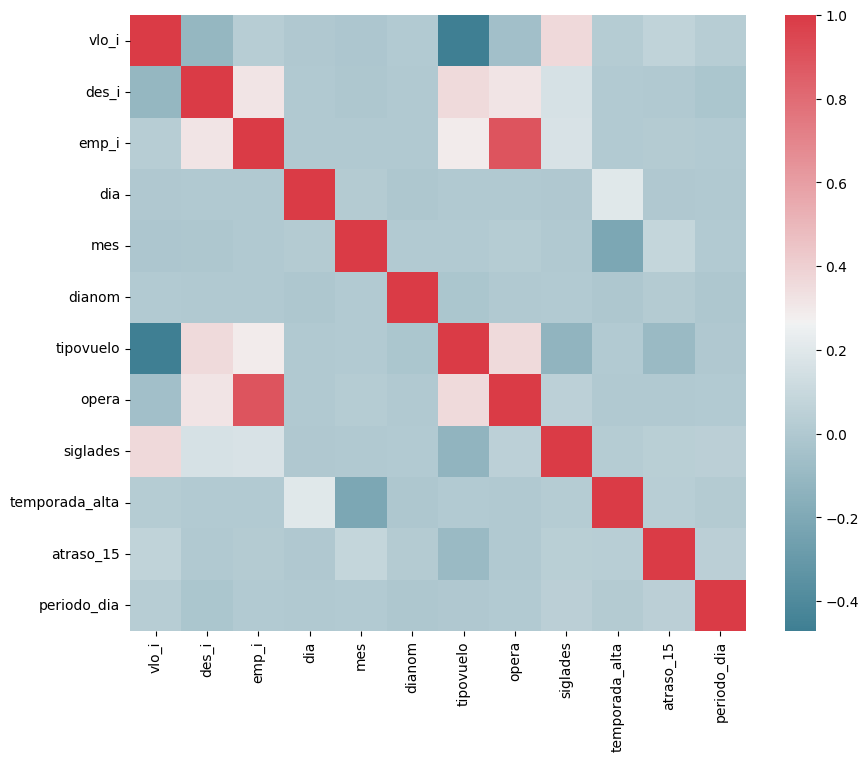

In [452]:
# Encode Categorical Columns only for Confussion Matrix rendering

df_categ = df.copy()

le = LabelEncoder()
df_categ[categoricals] = df_categ[categoricals].apply(le.fit_transform)


# run correlation matrix and plot
f, ax = plt.subplots(figsize=(10, 8))
corr = df_categ.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Balanceo de clases

Podemos ver un desbalance en la variable a predecir "atraso_15" (0-no atraso, 1-atraso), esto es un comportamiento normal para el caso de estudio, es eperable que la menor cantidad de casos no presenten retraso de llegada. Esta veriable será nuestro target a prdecir en el posterior análisis.

Los dataset desbalanceados pueden significar un problema a la hora de entrenar modelos, el cual se suele solucionar mediante técnicas de undersampling y/o oversampling.

<AxesSubplot:>

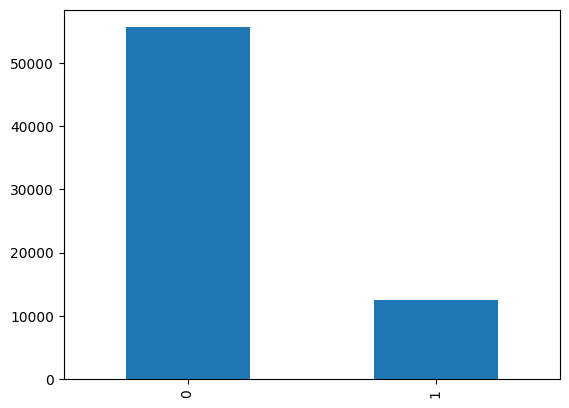

In [453]:
df.atraso_15.value_counts().plot.bar()

Existen diversos métodos de balanceo de clase, estas técnicas pueden ser divididas básicamente entre "undersampling" y "oversampling". La primera familia remite a modos de reducir la cantidad de casos pertenecientes a la categoría sobrerepresentada, la segunda familia remite a modos de aumentar la cantidad de casos pertenecientes a la categoría subrepresentada.

El Synthetic Minority Oversampling Technique (SMOTE) consiste en un método de oversampling sofisticado, el cual genera datos sintéticos. Este método de data augmentation suele resultan en mejores resultados de predicción frente a métodos de oversampling más rudimentarios como símplemente duplicar casos de la categoría subrepresentada.

A su vez, el SMOTE suele emplearce en combinación con métodos de Undersampling a modo de complemento (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/), aspecto que tendermos en consideración en nuestros modelos.

En el siguiente gráfico se ilustra el balanceamiento de nuestros datos mediante la técnia de SMOTE. Vale la pena aclarar que las variables "X_resampled" y "y_resampled" solo son generadas para esta ilustración y no serán empleadas en el entrenamiento del modelo, de esta manera evitamos tener "data leakage". El SMOTE se empleará dentro de un pipeline específico para no alterar las predicciones en los hold sets de validación, así como manteniendo intactos los datos de testeo.

<AxesSubplot:title={'center':'Class distribution after appying SMOTE'}>

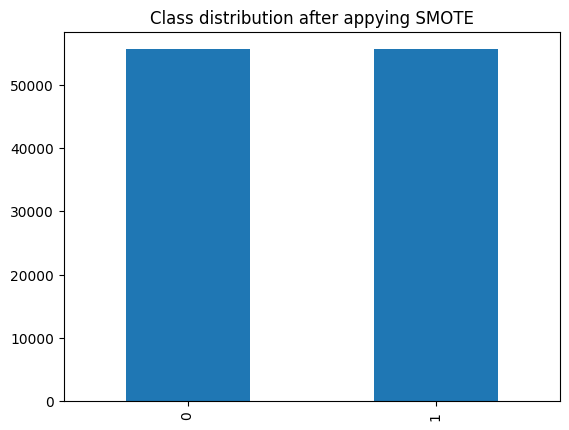

In [454]:
# Generamos una copia de los dataframes a modo de prevenir data leakage
X_categ = df_categ[categoricals]
y_categ = df_categ[predict]


# Generamos el gráfico de datos balanceados 
X_resampled, y_resampled = SMOTE().fit_resample(X_categ, y_categ)
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE')

### Train-Test Split

El siguiente paso es realizar "train test split" de nuestros datos. El mismo consiste en separar los datos en un set de entrenamiento y un set de testeo. En el primero entrenamos al modelo y utilzamos el segundo (datos no "vistos" por el modelo) para medir su performance predictiva.

In [455]:
indep_columns = df.loc[:,df.columns != predict]

X = indep_columns
y = df[predict]

In [456]:
# split X and y into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

### Pipelines & Data Leakage



### Encoding

Exisen principalmente 3 tipos de métodos para encodear variables: "One Hot Encoding", "Label Encoding", "Categorical Encoding".

En "One Hot Encoding" se generar una nueva variable categórica 1-0 por cada categoría de cada variable nominal. La principal virtud de este método es que no se imputan pesos ficticios a las categorías de cada variable. Lamentablemente en datasets con variables categóricas grandes (como el presente) realizar one hot encoding termina impactando en un aumento muy alto en el número de columnas, lo cual puede volver compuacionalmente muy extenso el entrenamiento de cualquier modelo. 

En "Label Encoding" símplemente se le asigna una etiqueta numérica a la categoría de cada variable regresora (ej. "rojo", "verde", "azul" pasan a ser "1", "2", "3") si bien esto es computacionalmente más ligero, uno debe tener en cuenta de que está asignando pesos ficticios al modelo (verde no es el doble de rojo, ni azul el triple de rojo).

"Categorical Encoding" es por otro lado un método muy empleado a la hora de tratar variables con muchas categorías ya que puede asignar un peso no arbitrario a cada una de estas categorías, sin generar una columna nueva por cada una de ellas.

En este trabajo usamos previamente Label Encoding de modo aislado y con fines ilustrativos para inspeccionar correlaciones entre las variables y para mostrar el balanceo del dataset. Ala hora de entrenar el modelo emplearemos Categorical Encoding ya que generamos previamente un criterio jerárquico de categorización en base al ratio de atraso (ver parte final del apartado 3 sobre ratio de atraso).

In [457]:
ord_enc = OrdinalEncoder(categories = categories)
column_transform = make_column_transformer((ord_enc, categoricals),
                                           remainder="passthrough")

### Standar Scaler

Es importante realiza un ajuste de standarización sobre las variables regresoras. Este ajuste o "normalización" cambia la escala de los valores a una media de 0 y desviación estandar de 1, gracias a los cual removemos el problema de que una variable medida en cantidades grandes tenga un impacto cesgado (ej. una variable puede estar medida en años y otra en grados, de no estandarizar le daríamos un peso ficticio mayor a la primer variable).

### Grid Search & Cross Validation

Finalmente realizamos el entrenamiento de nuestro modelo, sin dejar de lado dos técnicas más que nos ayudarán a mejorar el ajuste de nuestras predicciones: "Cross Validation" y "Grid Search".

El Cross Validation consiste en una técnica por la cual se define un conjunto de iteraciones de entrenamiento y en cada una de ellas se aparta un set de datos del set de entrenamiento a modo de generar un set de validación. Si por ejemplo definimos un 5 fold cross validation, queremos decir que estamos realizando 5 épocas de entrenamiento y en cada una de ellas separaremos un set aleatorio el cual usaremos como validación. Gracias a esta técnica la posibilidad de tener "overfitting" (un sobre ajuste a los datos de entrenamiento) se reduce de manera importante. 

Como complemento al Cross Validation realizamos Grid Search. Todos los modelos de Machine Learning presentan un basto conjunto de hiperparámetros, los cuales el cientista de datos debe probar ajustar en cada modelado, Grid Search nos permite definir posibles valores de algunos o todos estos parámetros y testear su performance en cada época del entrenamiento, para finalmente tomar los valores que den mejor resultado.

<a id=feature-eng-mod-2></a>

## 5.2 Logistic Regression

En terminos estadísticos el modelo más conocido y que usaremos como "base line" en este ejercicio es la regresión logística. En varias competencias Kaggle de predicción de atraso en vuelos, la regrasión logística surge como baseline model (https://www.kaggle.com/competitions/flight-delays-prediction-challeng2/overview)

La regresión logística es un método dentro de la familia de los modelos lineales generalizados, el cual posee el fin de predecir el comportamiento de una variable dependiente categórica en función de un conjunto de variables predictoras independientes. A diferencia del modelo d eregresión lineal, el logístico transforma la variable dependiente en un logaritmo a modo de que sus valores varíen como probabilidades entre 0 y 1.

<a id=feature-eng-mod-21></a>

### 5.2.1 Modeling

In [458]:

pipeline = Pipeline(steps = [['transformer', column_transform],
                                ['scaler', StandardScaler()],
                                ['smote', SMOTE(random_state=11)],
                                ['under_samp', RandomUnderSampler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='recall',
                           cv=5,
                           n_jobs=-1)

In [459]:
model_lgr = grid_search.fit(X_train, y_train)

In [460]:
cv_score = model_lgr.best_score_
test_score = model_lgr.score(X_test, y_test)
print(f'Cross-validation recall score: {cv_score}\nTest recall score: {test_score}')

Cross-validation recall score: 0.622424638320495
Test recall score: 0.6217310087173101


In [461]:
y_pred = model_lgr.predict(X_test)

<a id=feature-eng-mod-22></a>

### 5.2.2 Evaluation

Ya con los hiperparámetros ajustados y el modelo ajustado a los datos, procedimos a calcular las predicciones de la variable target en función de los datos de testeo (los "no vistos" por el modelo). Con ese proceso culminado nos queda evaluar la performance predictiva del modelo.

Para evaluar un modelo existen gran canitdad de métricas. Para los modelos de clasificación una herramienta comunmente utilizada es la matriz de confusión. La matriz de confusión consiste en una grilla de 2x2 con las columnas "predicción 0", "predicción 1" y las filas "actual 0", "actual 1", teniendo en las celdas los siguientes 4 valores: verdaderos negativos, falssos negativos, verdaderos positivos y falsos positivos. Con estos valores podemos calcular así que tan bien nuestro modelo acierta o no a cada una de estas categorías.

A continuación se muestra la matriz de confusión para nuestra regresión logística. En ella se observa claramente que nuestro modelo base tiene una gran cantidad de falsos negativos y consecuentemente muy pocos verdaderos positivos. Este es un problema típico cuando en datos desbalanceados (en nuestro caso la variable target presentaba un aprox 20% de casos con atraso y un 80% sin atraso, esto es un desbalance), al modelo aprende a clasificar gtran parte de los datos como 0 y logra un buen ratio de aciertos, pero descuida su precisión.

In [462]:
# import the metrics class

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[9271, 4569],
       [1215, 1997]])

Text(0.5, 427.9555555555555, 'Predicted label')

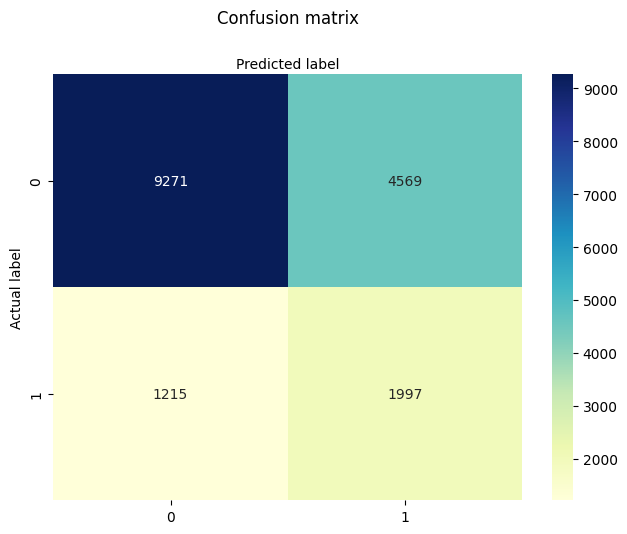

In [347]:
# import required modules

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


¿Cómo evaluamos el modelo entonces, fue bueno o malo? ¿predice mejor que símplemente tirar una moneda al aire y decir "si sale cara el avión se va a atrasar"? Claramente nuestro algoritmo debería tnener mayor poder explicativo q el azar y además deberíamos tomar una métrica que sea útil para el problema de negocio que estamos abordando. 

Con los valores de la matriz de confusión podemos generar cuatro métricas para finalmente medir la performance de nuestro modelo. Todas ellas varían entre 0 y 1, siendo 0 el pero valor y 1 el mejor:

- Accuracy: (True Positive + True Negative) / TOTAL
    Es la cantidad de correctas clasificaciones. Si bien tiene la virtud de ser fácil de interpretar, acarrea el problema de que en datos no balanceados un modelo que prediga el 95% como 0 puede tener un accuracy de 0.95 lo que parece ser muy bueno, pero no nos sirve como métrica útil en la realidad.

- Precision: True Positive / (True Positive + False Positive)
    Se enfoca en que tan bien el modelo predice los casos positivos, consiste en la proporción de verdaderos positivos sobre el total de positivos predecidos. La precisión nos responde la pregunta "¿qué proporción de positivos fue correctamente identificada?" (cuántos de los vuelos que predije se iban a atrasar, realmente se atrasaron).

- Recall: True Positive / (True Positive + False Positive)
    Consiste en la proporción de verdaderos positivos  sobre el real de valores positivos. El recall nos responde la pregunta "¿qué proporción de actuales positivos fueron correctamente identificados?" (de los vuelos que se atrasaron, cuántos logré predecir correctamente).

- F1 score: 2*(Precision*Recall) / (Precision + Recall)
    Consiste en la media harmónica entre el precision y el recall. Si bien esto lo vuelve más abstracto que las anteriores métricas le brinda la capacidad de combinarlas a ambas, siendo particularmente útil para la comparación entre modelos que quizás sean mejores en precisión pero peores en recall o viceversa.



Consideramos que en nuestro problema la clave es ser muy bueno acertando en las predicciones de que un vuelo se atrase, no así en la tasa de error de estas predicciones. 

Si hay un vuelo que se va a atrasar queremos ser muy buenos en poder predecirlo, en términos de negocio esto implica en poder avisar a tiempo a los pasajeros del atraso de su vuelo. Si un vuelo no se va a atrasar pero nuestro modelo predijo que lo haría el impácto de negocio no es tan grande, si los pasajeros fueron avisados de un atraso y el avión llega en hora puede extenderse brevemente el tiempod e despegue a modo de mantener la planificación.

Si bien estas decisiones deberían ser tomadas por expertos de negocio, podemos considerarlas en este ejercicio como válidas. De este modo el Precision y Recall serían dos métricas clave, y el F1-Score nuestro modo de comparar entre modelos.

In [463]:
target_names = ['no delay', 'with delay']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no delay       0.88      0.67      0.76     13840
  with delay       0.30      0.62      0.41      3212

    accuracy                           0.66     17052
   macro avg       0.59      0.65      0.59     17052
weighted avg       0.77      0.66      0.70     17052



Del anterior cuadrante podemos extraer los valores de Accuracy, Precision, Recall y F1-score, además del Support (cantidad de casos para cada categoría). A modo de simplificación podemos centrarnos en el weighted avg, dado que toma el promedio ponderado por la cantidad de casos. Así podmeos finalmente concluir que nuestro modelo presenta un 73% de precisión a la hora de predecir la proporción de vuelos atrasados correctamente identificados y un 81% de exhaustividad a la hora de evaluar la proporción de actuales vuelos atrasados. A la hora de comparar con otros modelos usaremos el 0.73 de f1-score.

En términos más coloquiales de cada 10 vuelos que nuestro modelo prediga que se van a atrasar, en promedio 7 de ellos se atrasarán efectivamente y 3 no se atrasarán. En términos coloquiales, de cada 10 vuelos q se atrasan, nuestro modelo predice corectamente 8 y se equivoca en 2.

In [464]:
lgr_featImp = model_lgr.best_estimator_[-1].coef_
lgr_featImp

array([[-0.61265339,  0.06035294, -0.04789402, -0.16349717,  0.01181903,
        -0.06338647, -0.07797041, -0.02232334, -0.03978221,  0.22997743,
         0.13880728]])

In [465]:
X.columns

Index(['vlo_i', 'des_i', 'emp_i', 'dia', 'mes', 'dianom', 'tipovuelo', 'opera',
       'siglades', 'temporada_alta', 'periodo_dia'],
      dtype='object')

In [466]:
# Extraemos los pesos explicativos de cada variable explicativa
coef_table = pd.DataFrame(list(X.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lgr_featImp.transpose())
print("Logistic Regression coefs")
print(coef_table)

Logistic Regression coefs
                 0     Coefs
0            vlo_i -0.612653
1            des_i  0.060353
2            emp_i -0.047894
3              dia -0.163497
4              mes  0.011819
5           dianom -0.063386
6        tipovuelo -0.077970
7            opera -0.022323
8         siglades -0.039782
9   temporada_alta  0.229977
10     periodo_dia  0.138807


Finalmente podemos procesar el peso de los features en el modelo logístico. Podemos ver que las variables con mayor peso explicativo son el código de la aerolínea de vuelo programado ("emp_i"), seguido con peso inversamente proporcional (negativo) por el código de la aerolínea de vuelo programado ("emp_o"), en tercer lugar y también inversamente proporcional el tipo de vuelo ("tipovuelo").

A la hora de ver estos valores es importante tener en consideración que nos son porcentajes directos, sería erróneo interpretar que el tipo de vuelo (internacional o nacional) impacta reduciendo un 20% la probabilidad de atraso, estos pesos no son lineales. También se debe tener en cuenta que las variables categóricas como el código de la aerolínea fueron label encodeadas con pesos arbitrarios, por lo que el peso marginal de cada categoría dentro de esta variable no es interpretable por fuera del modelo (no podemos decir "si el vuelo es de tal o cual aerolínea tiene un 42% más chances de llegar con retraso"). Las únicas afirmaciones que podemos realizar son el orden de peso explicativo de las variables, como se realiza en el párrafo anterior.

Pensando fuera del notebook y más en clave de producción, agregamos una celda para descargar los pesos de nuestro modelo en un archivo ".pkl" el cual puede ser importado posteriormente para ejecutar predicciones y así no tener que calcular de nuevo los pesos del modelo cada vez que tenga que ejecutarse.

In [467]:
# Exportamos los pesos del modelo en un archivo pickle

pkl_filename = os.path.join(models_path, "model_1.pkl")

with open(pkl_filename, 'wb') as file:
    pickle.dump(model_lgr, file)


<a id=feature-eng-mod-3></a>

## 5.4 XGBoost

XGBoost

## Explicar el algoritmo de XGBoost

In [384]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)


pipeline = make_pipeline(column_transform,
                        StandardScaler(),
                        SMOTE(),
                        #RandomUnderSampler(),
                        xgb_model)



# Set parameters values for grid
param_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    #"xgbclassifier__n_estimators": [100, 200, 400, 800, 1000],
    "xgbclassifier__max_depth": [1, 3, 5],
    #"xgbclassifier__max_depth": [1, 2, 3, 4, 5, 6],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__use_label_encoder": [False],
    "xgbclassifier__booster": ["gbtree"],
    "xgbclassifier__eval_metric": ["logloss"]}

# Make custom scoring metric
#scorer = make_scorer(f1_score, pos_label=1)
scorer = 'recall'

# Intantiate GridSearchCV
grid_search_cv = GridSearchCV(pipeline, param_grid, scoring = scorer, cv=5,
                           n_jobs=-1)

In [385]:
model = grid_search_cv.fit(X_train, y_train)

In [403]:
xgb_pred = model.predict(X_test)

In [404]:
xgb_cv_score = model.best_score_
xgb_test_score = model.score(X_test, y_test)
print(f'Cross-validation recall score: {xgb_cv_score}\nTest recall score: {xgb_test_score}')

Cross-validation recall score: 0.7053988937527571
Test recall score: 0.7568493150684932


In [405]:
cnf_matrix = metrics.confusion_matrix(y_test, xgb_pred)
cnf_matrix

array([[7097, 6743],
       [ 781, 2431]])

In [406]:
target_names = ['no delay', 'with delay']
print(classification_report(y_test, xgb_pred, target_names=target_names))

              precision    recall  f1-score   support

    no delay       0.90      0.51      0.65     13840
  with delay       0.26      0.76      0.39      3212

    accuracy                           0.56     17052
   macro avg       0.58      0.63      0.52     17052
weighted avg       0.78      0.56      0.60     17052



In [407]:
feat_imp = model.best_estimator_[-1].feature_importances_

In [408]:
X.columns

Index(['vlo_i', 'des_i', 'emp_i', 'dia', 'mes', 'dianom', 'tipovuelo', 'opera',
       'siglades', 'temporada_alta', 'periodo_dia'],
      dtype='object')

In [409]:
d = {'Stats':X.columns,'Coefs':feat_imp}
coefs = pd.DataFrame(d)
print("XGBoost coefs:")
print(coefs)

XGBoost coefs:
             Stats     Coefs
0            vlo_i  0.624769
1            des_i  0.000000
2            emp_i  0.000000
3              dia  0.096857
4              mes  0.000000
5           dianom  0.000000
6        tipovuelo  0.000000
7            opera  0.000000
8         siglades  0.000000
9   temporada_alta  0.278374
10     periodo_dia  0.000000


<BarContainer object of 11 artists>

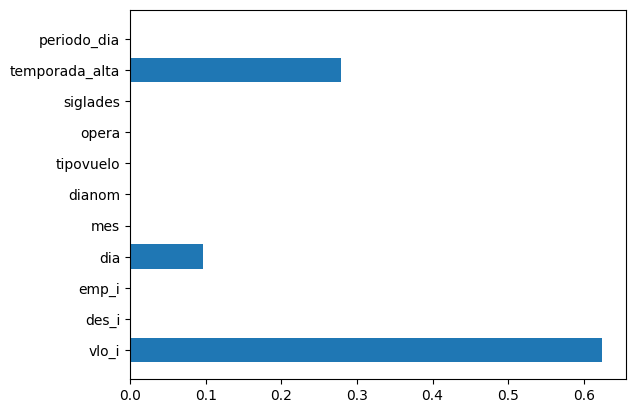

In [410]:
plt.barh(X.columns, feat_imp)

In [411]:
# Exportamos los pesos del modelo en un archivo pickle

pkl_filename = os.path.join(models_path, "model_2.pkl")

with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

<a id=considerations></a>

# 6. Considerations and Further Analysis

¿Qué pasos seguir ahora? Este notebook debe ser considerado como un primer análisis no exhaustivo, la investigación en ciencia de datos consiste en un contínuo proceso de eploración de datos, generación de hipótesis, modelado, testeo, reformulación, puesta en producción y continuo desarrollo.

Un primer aspecto a seguir puliendo sería mejorar el feature engineering. No todos los cruces de variables del punto 3 (tasa de atraso) fueron explotados exhaustivamente. La tasa de atraso filtrada por aerolínea nos daría un muy interesante insight para categorizar la variable aerolínea en "atraso_alto", "atraso_medio", "atraso_bajo" y esto seguramente impacte como un buen regresor en un modelo logístico. Este ejemplo también tiene sus implicaciones a considerar, si a futuro el modelo está en producción y una compañía aerea mejora su tasa de atraso, esta mejora puede ser omitida por le modelo y generar predicciones erróneamente cesgadas.

Otro aspecto es tomar en consideración incluir variables externas a este dataset. Por ejemplo, la librería Pandas presenta una API llamada GeoPandas (https://geopandas.org/en/stable/), con la cual se puede dado el nombre de una localidad geográfica consultar su latitud y longitud. Esta extracción es muy sencilla de realizar, si luego a partir de ello se calcula la distancia de la ciuad de origen a la ciudad de destino obtenemos una nueva variable regresora de gran poder. Nuevamente hay que pensar en las implicancias de este nuevo feature, los vuelos no son recorridos lineales del punto A al B, y las alturas son variables clave que afectan la distancia a su vez.

Un tercer comentario es la revisión de qué otros abordajes se han hecho. Más allá del comentario previo sobre competiciones Kaggle de predicción de atraso en vuelos, en el mundo empresarial también encontramos antecedentes que lidian con este problema. En el siguiente artículo se muestra el caso de la aerolínea Lufthansa, la cual empleando Vertex AI Forecasting - solución de inteligencia artificial de Google Cloud - logró incorporar datos climáticos sobre niveles de viento a su monitoreo de vuelos, con lo cual pudieron reducir problemas de retraso y cancelación de vuelos: https://cloud.google.com/blog/products/ai-machine-learning/how-lufthansa-reduce-flight-delays-with-google-cloud-ml.

Como agregado final, podría evaluarse también la generación de una estructura de clases para el archivo utils.py (por ejemplo, crear una clase TransformData), lo cual permitiría crecer en funcionalidades de una manera ordenada y que, además, simplificaría un potencial pasaje a producción luego.

A modo de cierre, logramos en este notebook importar, procesas y describir un conjunto de datos. Logramos entrenar dos modelos de clasificación, los cuales pueden predecir retraso de vuelos frente a data no vista con una mejor métrica que el puro azar. Logramos también seguir ciertos buenos estándares en términos de desarrollo de software, pensando en que el código de un notebook debe poder ser reutilizado y migrado dinámicamente a un ambiente de producción: tener un gitflow y un repositorio, requerimientos separados, un archivo .py con nuestras funciones locales y salvar los pesos de nuestros modelos son prácticas no menores que optimizan el día a día de un proyecto de data.


